In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator 
import spacy



/space/hotel/bachn/miniconda3/envs/m2f/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data and split train, val, set

In [2]:
train_data = []
train_set_path = 'data/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

# Load val data
val_data = []
val_set_path = 'data/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

# Load test data
test_data = []
test_set_path = 'data/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')
        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()
            
        data_sample = {
            'image_path': temp [0][:-2] ,
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)


## Processing data

### Build vocab

In [3]:
eng = spacy.load ("en_core_web_sm") # Load the English model to tokenize
def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']
        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])


### Build dictionary mapping classes

In [4]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}


### Build tokenizer

In [5]:
def tokenize(question, max_sequence_length):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_sequence_length:
        sequence += [vocab['<pad>']] * (max_sequence_length - len(sequence))
    else:
        sequence = sequence[:max_sequence_length]

    return sequence

### Pytorch dataset loader Image procesing

In [6]:
from torchvision import transforms

class VQADataset(Dataset):
    def __init__(self, data, classes_to_idx, max_seq_len=30, transform=None, root_dir='/space/hotel/bachn/VQA/data/val2014-resised'):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = self.classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

# Image preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


In [7]:
train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)



## Model CNN+LSTM

In [8]:
import timm
import torch
import torch.nn as nn

class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet50',
        embedding_dim=300,
        n_layers=2,
        hidden_size=128,
        dropout_prob=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.layernorm = nn.LayerNorm(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 3, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)

        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.layernorm(lstm_out)

        combined = torch.cat((img_features, lstm_out), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Model instantiation
n_classes = len(classes)
img_model_name = 'resnet50'
hidden_size = 128
n_layers = 1
embedding_dim = 128
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob
).to(device)


## Traing and evaluate

In [9]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses


In [10]:
lr = 1e-2
epochs = 50
weight_decay = 1e-5
scheduler_step_size = int(epochs * 0.6)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

# Training process
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)


EPOCH 1:	Train loss: 0.7687	Val loss: 51.6574	Val Acc: 0.5056352459016393
EPOCH 2:	Train loss: 0.7071	Val loss: 0.6915	Val Acc: 0.5358606557377049
EPOCH 3:	Train loss: 0.6927	Val loss: 0.6917	Val Acc: 0.5358606557377049
EPOCH 4:	Train loss: 0.6927	Val loss: 0.6916	Val Acc: 0.5358606557377049
EPOCH 5:	Train loss: 0.6952	Val loss: 0.6910	Val Acc: 0.5358606557377049
EPOCH 6:	Train loss: 0.6930	Val loss: 0.6907	Val Acc: 0.5358606557377049
EPOCH 7:	Train loss: 0.6929	Val loss: 0.6911	Val Acc: 0.5358606557377049
EPOCH 8:	Train loss: 0.6928	Val loss: 0.6922	Val Acc: 0.5358606557377049
EPOCH 9:	Train loss: 0.6926	Val loss: 0.6906	Val Acc: 0.5358606557377049
EPOCH 10:	Train loss: 0.6926	Val loss: 0.6908	Val Acc: 0.5358606557377049
EPOCH 11:	Train loss: 0.7458	Val loss: 2.6224	Val Acc: 0.5338114754098361
EPOCH 12:	Train loss: 0.7150	Val loss: 0.6911	Val Acc: 0.5358606557377049
EPOCH 13:	Train loss: 0.6928	Val loss: 0.6908	Val Acc: 0.5358606557377049
EPOCH 14:	Train loss: 0.6931	Val loss: 0.6913	

In [11]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)


Evaluation on val/test dataset
Val accuracy: 0.5358606557377049
Test accuracy: 0.5489614243323442


In [15]:
val_losses

[51.65739852874005,
 0.6915043211374127,
 0.691749095916748,
 0.6915912725886361,
 0.690957492492238,
 0.6907167268581078,
 0.6910856639752623,
 0.6922175903789333,
 0.6906234250694024,
 0.6907792052284616,
 2.6224018384198673,
 0.6910580504136007,
 0.690845856901075,
 0.6912788250407235,
 0.6922926238325776,
 0.6914237815825666,
 0.6913162479635144,
 0.6924039008187466,
 0.6921307708396286,
 0.692557731612784,
 0.6913460072923879,
 0.6908760334624618,
 0.6922679279671341,
 0.6909837800948346,
 0.6906060566667651,
 0.6907985962805201,
 0.6912610872847135,
 0.6906409918284807,
 0.6919607363763403,
 0.6907590588585275,
 0.6909619794517267,
 0.6911421027339872,
 0.691261787883571,
 0.691235788532945,
 0.6913474671176223,
 0.6912742462314543,
 0.6912711448356753,
 0.6912901421062282,
 0.691297746095501,
 0.6913610198458687,
 0.6911618826819248,
 0.6912970073887559,
 0.691236783246525,
 0.691214063128487,
 0.6912446627851392,
 0.6912962970186453,
 0.691307499760487,
 0.6912392250827102,
 0.

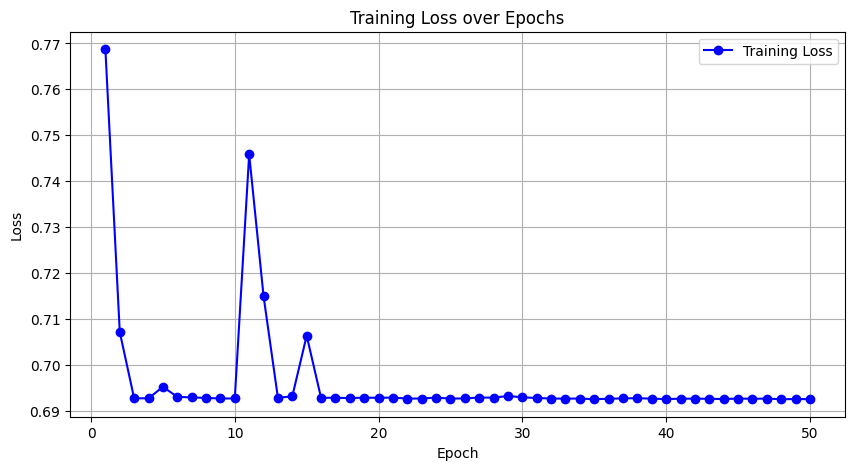

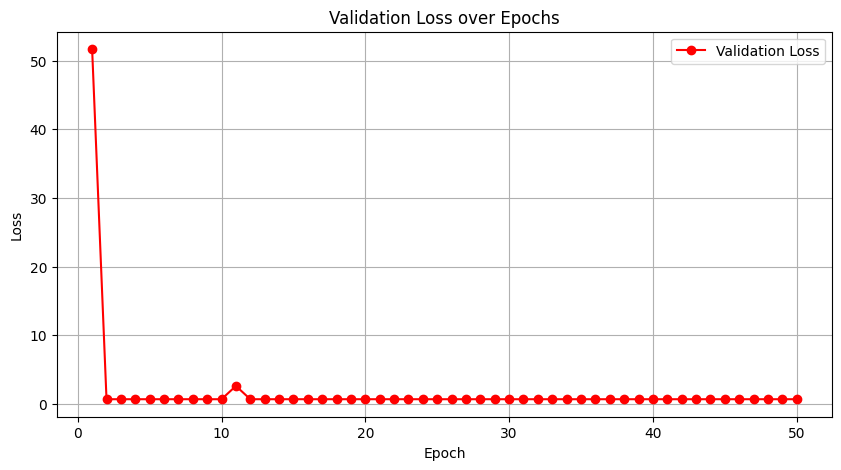

In [16]:
import matplotlib.pyplot as plt

# Assuming you have `train_losses` and `val_losses` lists from your training process
epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
